# # Tree Canopy Percentage, Green Space, and Air Quality Correlation to Acute Respiratory Illnesses in Ohio cities (2016 Data) (Part 1)

1. Data Wrangling

In [684]:
import numpy as np
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import pickle
import seaborn as sns
%matplotlib inline
import string
import collections

from pandas.plotting import register_matplotlib_converters
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.feature_extraction import text

#### Importing Datasets

#### Part 1: AQI values

I. Cincinnati, OH-KY-IN

To accurately describe changes in air quality for locations and time periods with biases in the monitoring network, we apply rolling window regression. This recursively calculates the change in pollutant concentration as a function of time, which can be used as a proxy for the true trend. This also more accurately reflects the true trend than averaging the time series. It can smooth random short-term variations. We will use simple moving average (SMA), cumulative moving average (CMA), exponential moving average, and estimating trends in NO2, CO, Ozone.

In [685]:
df_cinci = pd.read_csv(r'C:\Users\yuvem\OneDrive\Documents\GitHub\Tree-Canopy-Percentage-Air-Quality-Correlation-to-Acute-Resp-Illnesses-in-Ohio-cities-Project_\ad_viz_tile_data.csv')
df_cinci.head()

,Date,AQI_Value,Main_Pollutant,Site_Name,Site_ID,Source
0,1/1/2019,23,PM2.5,Sycamore,39-061-0006,AQS
1,1/2/2019,48,PM2.5,Cincinnati Near Road,39-061-0048,AQS
2,1/3/2019,56,PM2.5,NORTHERN KENTUCKY UNIVERSITY (NKU),21-037-3002,AQS
3,1/4/2019,59,PM2.5,Cincinnati Near Road,39-061-0048,AQS
4,1/5/2019,45,PM2.5,Taft NCore,39-061-0040,AQS


In [686]:
df_cinci.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Date            365 non-null    object
 1    AQI_Value      365 non-null    int64 
 2   Main_Pollutant  365 non-null    object
 3   Site_Name       365 non-null    object
 4   Site_ID         365 non-null    object
 5   Source          365 non-null    object
dtypes: int64(1), object(5)
memory usage: 17.2+ KB


In [687]:
df_cinci.shape

(365, 6)

In [688]:
df_cinci.isnull().sum()

Date              0
 AQI_Value        0
Main_Pollutant    0
Site_Name         0
Site_ID           0
Source            0
dtype: int64

In [689]:
df_cinci['Date'] = pd.to_datetime(df_cinci['Date'])

In [690]:
# calculate the yearly average CO AQI 
df_cinci['AQI_Value'] = df_cinci.mean(axis=1)

# drop columns containing monthly values
df_aqi_cinci = df_cinci[['AQI_Value']]

# visualize the first 5 columns
df_aqi_cinci.head()

<ipython-input-690-ce99a4d9517a>:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df_cinci['AQI_Value'] = df_cinci.mean(axis=1)


,AQI_Value
0,23.0
1,48.0
2,56.0
3,59.0
4,45.0


II. Cleveland-Elyria, OH

In [691]:
df_cle = pd.read_csv(r'C:\Users\yuvem\OneDrive\Documents\GitHub\Tree-Canopy-Percentage-Air-Quality-Correlation-to-Acute-Resp-Illnesses-in-Ohio-cities-Project_\ad_viz_tile_data_cle.csv')
df_cle.head()

,Date,AQI_Value,Main_Pollutant,Site_Name,Site_ID,Source
0,1/1/2019,39,PM2.5,GT Craig NCore,39-035-0060,AQS
1,1/2/2019,55,PM2.5,GT Craig NCore,39-035-0060,AQS
2,1/3/2019,48,PM2.5,GT Craig NCore,39-035-0060,AQS
3,1/4/2019,66,PM2.5,GT Craig NCore,39-035-0060,AQS
4,1/5/2019,83,PM2.5,GT Craig NCore,39-035-0060,AQS


In [692]:
df_cle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Date            365 non-null    object
 1    AQI_Value      365 non-null    int64 
 2   Main_Pollutant  365 non-null    object
 3   Site_Name       365 non-null    object
 4   Site_ID         365 non-null    object
 5   Source          365 non-null    object
dtypes: int64(1), object(5)
memory usage: 17.2+ KB


In [693]:
df_cle.shape

(365, 6)

In [694]:
df_cle.isnull().sum()

Date              0
 AQI_Value        0
Main_Pollutant    0
Site_Name         0
Site_ID           0
Source            0
dtype: int64

In [695]:
df_cle['Date']= pd.to_datetime(df_cle['Date'])

In [696]:
# calculate the yearly average CO AQI 
df_cle['AQI_Value'] = df_cle.mean(axis=1)

# drop columns containing monthly values
df_aqi_cle = df_cle[['AQI_Value']]

# visualize the first 5 columns
df_aqi_cle.head()

<ipython-input-696-b4c16b80b81e>:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df_cle['AQI_Value'] = df_cle.mean(axis=1)


,AQI_Value
0,39.0
1,55.0
2,48.0
3,66.0
4,83.0


### Rows and Columns for Main Pollutant PM2.5

In [697]:
pm25_cle = df_cle[df_cle["Main_Pollutant"] == "PM2.5"]
pm25_cle.shape

(214, 7)

In [698]:
pm25_cinci = df_cinci[df_cinci["Main_Pollutant"] == "PM2.5"]
pm25_cinci.shape

(192, 7)

In [699]:
df_cle.head()

,Date,AQI_Value,Main_Pollutant,Site_Name,Site_ID,Source,AQI_Value
0,2019-01-01,39,PM2.5,GT Craig NCore,39-035-0060,AQS,39.0
1,2019-01-02,55,PM2.5,GT Craig NCore,39-035-0060,AQS,55.0
2,2019-01-03,48,PM2.5,GT Craig NCore,39-035-0060,AQS,48.0
3,2019-01-04,66,PM2.5,GT Craig NCore,39-035-0060,AQS,66.0
4,2019-01-05,83,PM2.5,GT Craig NCore,39-035-0060,AQS,83.0


### Merge the two dataframes - Outer merge

In [700]:
outer_merged = pd.merge(df_cinci, df_cle, how="outer", on=["AQI_Value", "Main_Pollutant"] )

In [701]:
outer_merged.head()

,Date_x,AQI_Value_x,Main_Pollutant,Site_Name_x,Site_ID_x,Source_x,AQI_Value,Date_y,AQI_Value_y,Site_Name_y,Site_ID_y,Source_y
0,2019-01-01,23.0,PM2.5,Sycamore,39-061-0006,AQS,23.0,NaT,NaN,NaN,NaN,NaN
1,2019-01-02,48.0,PM2.5,Cincinnati Near Road,39-061-0048,AQS,48.0,2019-01-03,48.0,GT Craig NCore,39-035-0060,AQS
2,2019-01-02,48.0,PM2.5,Cincinnati Near Road,39-061-0048,AQS,48.0,2019-01-14,48.0,Cleveland Near Road,39-035-0073,AQS
3,2019-01-02,48.0,PM2.5,Cincinnati Near Road,39-061-0048,AQS,48.0,2019-03-06,48.0,Cleveland Near Road,39-035-0073,AQS
4,2019-01-02,48.0,PM2.5,Cincinnati Near Road,39-061-0048,AQS,48.0,2019-04-08,48.0,Cleveland Near Road,39-035-0073,AQS


### Complete merge of dataframes with Main Pollutant PM2.5

In [702]:
pm25_df = pm25_cle.join(pm25_cinci, lsuffix='_left', rsuffix='_right')
pm25_df.head()

,Date_left,AQI_Value_left,Main_Pollutant_left,Site_Name_left,Site_ID_left,Source_left,AQI_Value_left,Date_right,AQI_Value_right,Main_Pollutant_right,Site_Name_right,Site_ID_right,Source_right,AQI_Value_right
0,2019-01-01,39,PM2.5,GT Craig NCore,39-035-0060,AQS,39.0,2019-01-01,23.0,PM2.5,Sycamore,39-061-0006,AQS,23.0
1,2019-01-02,55,PM2.5,GT Craig NCore,39-035-0060,AQS,55.0,2019-01-02,48.0,PM2.5,Cincinnati Near Road,39-061-0048,AQS,48.0
2,2019-01-03,48,PM2.5,GT Craig NCore,39-035-0060,AQS,48.0,2019-01-03,56.0,PM2.5,NORTHERN KENTUCKY UNIVERSITY (NKU),21-037-3002,AQS,56.0
3,2019-01-04,66,PM2.5,GT Craig NCore,39-035-0060,AQS,66.0,2019-01-04,59.0,PM2.5,Cincinnati Near Road,39-061-0048,AQS,59.0
4,2019-01-05,83,PM2.5,GT Craig NCore,39-035-0060,AQS,83.0,2019-01-05,45.0,PM2.5,Taft NCore,39-061-0040,AQS,45.0


## Plotting Moving Average for all AQI Pollutants for Cincinnati and Cleveland

In [703]:
df_cinci2 = pd.read_csv(r'C:\Users\yuvem\OneDrive\Documents\GitHub\Tree-Canopy-Percentage-Air-Quality-Correlation-to-Acute-Resp-Illnesses-in-Ohio-cities-Project_\ad_viz_tile_data.csv', parse_dates=['Date'], index_col=['Date'], na_values=['.'], encoding='utf-8')
df_cinci2.head()

,AQI_Value,Main_Pollutant,Site_Name,Site_ID,Source
Date,,,,,
2019-01-01,23,PM2.5,Sycamore,39-061-0006,AQS
2019-01-02,48,PM2.5,Cincinnati Near Road,39-061-0048,AQS
2019-01-03,56,PM2.5,NORTHERN KENTUCKY UNIVERSITY (NKU),21-037-3002,AQS
2019-01-04,59,PM2.5,Cincinnati Near Road,39-061-0048,AQS
2019-01-05,45,PM2.5,Taft NCore,39-061-0040,AQS


In [704]:
# calculate the yearly average AQI 
df_cinci2['AQI_Value'] = df_cinci2.mean(axis=1)

# drop columns containing monthly values
df_aqi_cinci2 = df_cinci2[['AQI_Value']]

# visualize the first 5 columns
df_aqi_cinci2.head()

,AQI_Value
Date,
2019-01-01,23.0
2019-01-02,48.0
2019-01-03,56.0
2019-01-04,59.0
2019-01-05,45.0


In [705]:
df_cle2 = pd.read_csv(r'C:\Users\yuvem\OneDrive\Documents\GitHub\Tree-Canopy-Percentage-Air-Quality-Correlation-to-Acute-Resp-Illnesses-in-Ohio-cities-Project_\ad_viz_tile_data_cle.csv', parse_dates=['Date'], index_col=['Date'], na_values=['.'], encoding='utf-8')
df_cle2.head()

,AQI_Value,Main_Pollutant,Site_Name,Site_ID,Source
Date,,,,,
2019-01-01,39,PM2.5,GT Craig NCore,39-035-0060,AQS
2019-01-02,55,PM2.5,GT Craig NCore,39-035-0060,AQS
2019-01-03,48,PM2.5,GT Craig NCore,39-035-0060,AQS
2019-01-04,66,PM2.5,GT Craig NCore,39-035-0060,AQS
2019-01-05,83,PM2.5,GT Craig NCore,39-035-0060,AQS


In [706]:
# calculate the yearly average AQI 
df_cle2['AQI_Value'] = df_cle2.mean(axis=1)

# drop columns containing monthly values
df_aqi_cle2 = df_cle2[['AQI_Value']]

# visualize the first 5 columns
df_aqi_cle2.head()

,AQI_Value
Date,
2019-01-01,39.0
2019-01-02,55.0
2019-01-03,48.0
2019-01-04,66.0
2019-01-05,83.0


In [707]:
aqi_df = df_aqi_cle2.join(df_aqi_cinci2, lsuffix='_left', rsuffix='_right')
aqi_df.head()

,AQI_Value_left,AQI_Value_right
Date,,
2019-01-01,39.0,23.0
2019-01-02,55.0,48.0
2019-01-03,48.0,56.0
2019-01-04,66.0,59.0
2019-01-05,83.0,45.0


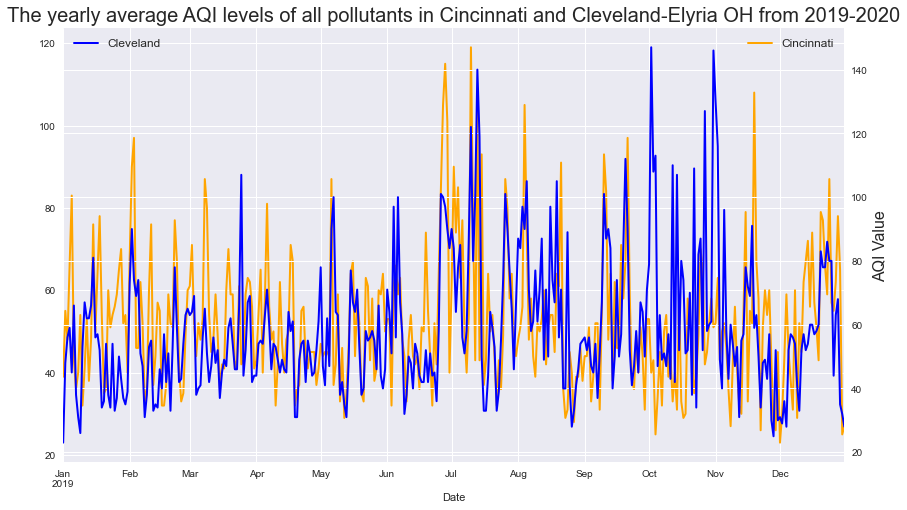

In [708]:
plt.style.use('seaborn')
plt.figure(figsize=(14,8))

# line plot - the yearly average AQI in Cinicinnati OH-KY-IN and Cleveland-Elyria, OH
ax1 = aqi_df['AQI_Value_left'].plot(color='orange', linewidth=2, grid=True, label='Cincinnati')
ax2 = aqi_df['AQI_Value_right'].plot(color='blue', linewidth=2, grid=True, label='Cleveland', secondary_y=True)
ax1.legend(fontsize=12, loc=1)
ax2.legend(fontsize=12, loc=2)

# title and labels
plt.title('The yearly average AQI levels of all pollutants in Cincinnati and Cleveland-Elyria OH from 2019-2020', fontsize=20)
plt.xlabel('Year', fontsize=16)
plt.ylabel('AQI Value', fontsize=16)
plt.show()

#### Moving Average over a period of 10 years

In [709]:
# the simple moving average over a period of 10 years for Cinicinnati
df_cinci2['SMA_10'] = df_cinci2.AQI_Value.rolling(10, min_periods=1).mean()

# the simple moving average over a period of 20 year
df_cinci2['SMA_20'] = df_cinci2.AQI_Value.rolling(20, min_periods=1).mean()

In [710]:
# the simple moving average over a period of 10 years
df_cle2['SMA_10'] = df_cle2.AQI_Value.rolling(10, min_periods=1).mean()

# the simple moving average over a period of 20 year
df_cle2['SMA_20'] = df_cle2.AQI_Value.rolling(20, min_periods=1).mean()

Text(0, 0.5, 'AQI Value')

<Figure size 1008x576 with 0 Axes>

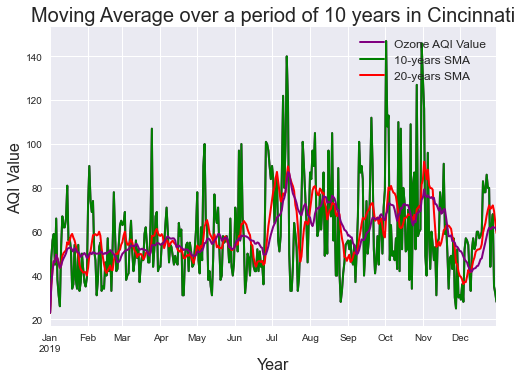

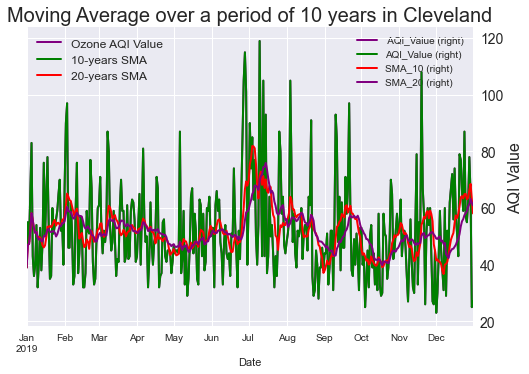

In [711]:
plt.figure(figsize=(14,8))

# colors for the line plot
colors = ['purple', 'green', 'red']

# line plot - the yearly average air temperature in Barcelona
ax1 = df_cinci2.plot(color=colors, linewidth=2, grid=True, label='Cincinnati')
ax2 = df_cle2.plot(color=colors, linewidth=2, grid=True, label='Cleveland', secondary_y=True)
ax1.legend(labels =['Ozone AQI Value', '10-years SMA', '20-years SMA'], fontsize=12, loc=1)
ax2.legend(labels =['Ozone AQI Value', '10-years SMA', '20-years SMA'], fontsize=12, loc=2)

# modify ticks size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# title and labels
ax1.set_title('Moving Average over a period of 10 years in Cincinnati', fontsize=20)
ax1.set_xlabel('Year', fontsize=16)
ax1.set_ylabel('AQI Value', fontsize=16)
ax2.set_title('Moving Average over a period of 10 years in Cleveland', fontsize=20)
ax2.set_xlabel('Year', fontsize=16)
ax2.set_ylabel('AQI Value', fontsize=16)

#### Cumulative moving average

In [712]:
# cumulative moving average
df_cinci2['CMA'] = df_cinci2.AQI_Value.expanding().mean()

In [713]:
# cumulative moving average
df_cle2['CMA'] = df_cle2.AQI_Value.expanding().mean()

Text(0, 0.5, 'AQI Value')

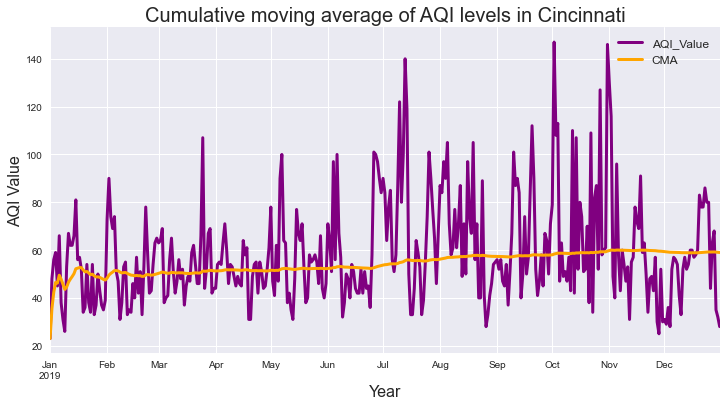

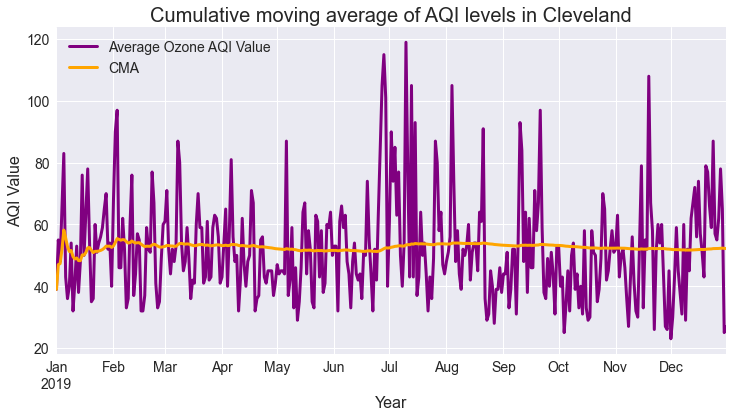

In [714]:
# colors for the line plot
colors = ['purple', 'orange']

# line plot - the yearly average air temperature in Barcelona
ax1 = df_cinci2[['AQI_Value', 'CMA']].plot(color=colors, linewidth=3, figsize=(12,6))
ax2 = df_cle2[['AQI_Value', 'CMA']].plot(color=colors, linewidth=3, figsize=(12,6))
ax1.legend(fontsize=12, loc=1)
ax2.legend(fontsize=12, loc=2)

# modify ticks size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(labels =['Average Ozone AQI Value', 'CMA'], fontsize=14)

# title and labels
ax1.set_title('Cumulative moving average of AQI levels in Cincinnati', fontsize=20)
ax1.set_xlabel('Year', fontsize=16)
ax1.set_ylabel('AQI Value', fontsize=16)
ax2.set_title('Cumulative moving average of AQI levels in Cleveland', fontsize=20)
ax2.set_xlabel('Year', fontsize=16)
ax2.set_ylabel('AQI Value', fontsize=16)

## Analysis on Pollution using EnviroAtlas and Tableau

Here, we use [EnviroAtlas](https://enviroatlas.epa.gov/enviroatlas/interactivemap/) metadata to look at several metrics assessing pollution in the Cincinnati and Cleveland. This includes enviornmental impacts and an evaluation on pollutant reduction removed annually by tree cover, category being air. We will also use Tableau to visualize distributions and trends.

In [715]:
ds_ppm = pd.read_csv(r'C:\Users\yuvem\OneDrive\Documents\GitHub\Tree-Canopy-Percentage-Air-Quality-Correlation-to-Acute-Resp-Illnesses-in-Ohio-cities-Project_\Percent particulate matter [PM2.5] removed annually by tree cover.csv')
ds_ppm.head()

,OBJECTID,Shape,Block group id,EnviroAtlas Community Code,Value of hospital admissions avoided due to nitrogen dioxide removed ($/yr),Asthma exacerbation avoided due to nitrogen dioxide removed (cases/yr),Value of asthma exacerbation cases avoided due to nitrogen dioxide removed ($/yr),Acute respiratory symptoms avoided due to ozone removed (cases/yr),Value of mortality avoided due to ozone removed ($/yr),School days not lost to illness due to ozone removed (days/yr),...,Population in 0.2% Annual Chance Flood Hazard area - Percent,EnviroAtlas Community Name,State FIPS,County FIPS,Tract FIPS,ALAND10,AWATER10,ORIG_FID,x,y
0,1377,NaN,390351029001,CleOH,31.663301,0.506055,42.571114,0.429964,2467.581643,0.235603,...,-99999.0,"Cleveland, OH",39,35,102900,273127,0,1377,NaN,NaN
1,1378,NaN,390351029002,CleOH,50.024222,0.799511,67.257635,0.679313,3898.603387,0.372235,...,-99999.0,"Cleveland, OH",39,35,102900,241577,0,1378,NaN,NaN
2,1380,NaN,390351033001,CleOH,28.721144,0.387625,32.151481,0.488927,2476.856159,0.168493,...,-99999.0,"Cleveland, OH",39,35,103300,503612,70710,1380,NaN,NaN
3,1386,NaN,390351036021,CleOH,21.873868,0.085754,7.183643,0.323015,1470.922223,0.038107,...,-99999.0,"Cleveland, OH",39,35,103602,1366152,1313815,1386,NaN,NaN
4,1387,NaN,390351036022,CleOH,35.251860,0.138200,11.577034,0.520552,2370.447882,0.061411,...,-99999.0,"Cleveland, OH",39,35,103602,245455,0,1387,NaN,NaN


In [716]:
ds_ppm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 712 entries, 0 to 711
Columns: 128 entries, OBJECTID to y
dtypes: float64(91), int64(35), object(2)
memory usage: 712.1+ KB


In [717]:
dfo = ds_ppm.select_dtypes(include=['object'])
dfo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 712 entries, 0 to 711
Data columns (total 2 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   EnviroAtlas Community Code  712 non-null    object
 1   EnviroAtlas Community Name  712 non-null    object
dtypes: object(2)
memory usage: 11.2+ KB


In [718]:
ds_ppm = ds_ppm.drop(columns='Block group id')
ds_ppm = ds_ppm.drop(columns='Shape')
ds_ppm = ds_ppm.drop(columns='EnviroAtlas Community Code')
ds_ppm = ds_ppm.drop(columns='Number of schools (K-12)')
ds_ppm = ds_ppm.drop(columns='Land area in 1% Annual Chance Flood Hazard area - Area (m2)')
ds_ppm = ds_ppm.drop(columns='Land area in 1% Annual Chance Flood Hazard area - Percent')
ds_ppm = ds_ppm.drop(columns='Land area in 0.2% Annual Chance Flood Hazard area - Area (m2)')
ds_ppm = ds_ppm.drop(columns='Land area in 0.2% Annual Chance Flood Hazard area - Percent')
ds_ppm = ds_ppm.drop(columns='Impervious surface in 1% Annual Chance Flood Hazard area - Area (m2)')
ds_ppm = ds_ppm.drop(columns='Impervious surface in 1% Annual Chance Flood Hazard area - Percent')
ds_ppm = ds_ppm.drop(columns='Impervious surface in 0.2% Annual Chance Flood Hazard area - Area (m2)')
ds_ppm = ds_ppm.drop(columns='Impervious surface in 0.2% Annual Chance Flood Hazard area - Percent')
ds_ppm = ds_ppm.drop(columns='Population in 1% Annual Chance Flood Hazard area - Total')
ds_ppm = ds_ppm.drop(columns='Population in 1% Annual Chance Flood Hazard area - Percent')
ds_ppm = ds_ppm.drop(columns='Population in 0.2% Annual Chance Flood Hazard area - Total')
ds_ppm = ds_ppm.drop(columns='Population in 0.2% Annual Chance Flood Hazard area - Percent')
ds_ppm = ds_ppm.drop(columns='State FIPS')
ds_ppm = ds_ppm.drop(columns='County FIPS')
ds_ppm = ds_ppm.drop(columns='Tract FIPS')
ds_ppm = ds_ppm.drop(columns='x')
ds_ppm = ds_ppm.drop(columns='y')
ds_ppm = ds_ppm.drop(['Population under 1 year old','Population under 13 years old','Population over 70 years old','Population other than White, non-Hispanic','Population with income below twice the US poverty level','Number of day care centers','K-12 schools with < 25 percent green space in viewshed','Reduction in mean load of total Kjeldahl nitrogen [TKN] (kg/yr)'],axis =1)

In [719]:
ds_ppm.head()

,OBJECTID,Value of hospital admissions avoided due to nitrogen dioxide removed ($/yr),Asthma exacerbation avoided due to nitrogen dioxide removed (cases/yr),Value of asthma exacerbation cases avoided due to nitrogen dioxide removed ($/yr),Acute respiratory symptoms avoided due to ozone removed (cases/yr),Value of mortality avoided due to ozone removed ($/yr),School days not lost to illness due to ozone removed (days/yr),Value of school days not lost to illness due to ozone removed ($/yr),Acute respiratory symptoms avoided due to particulate matter [PM2.5] removed (cases/yr),Value of mortality avoided due to particulate matter [PM2.5] removed ($/yr),...,Percent ozone removed annually by tree cover,Percent particulate matter [PM10] removed annually by tree cover,Percent particulate matter [PM2.5] removed annually by tree cover,Percent sulfur dioxide removed annually by tree cover,Daily domestic use (x1000 gal/day),bgrp,EnviroAtlas Community Name,ALAND10,AWATER10,ORIG_FID
0,1377,31.663301,0.506055,42.571114,0.429964,2467.581643,0.235603,23.133884,0.241419,6914.820192,...,0.113825,0.162079,0.064822,0.085713,66.384003,390351029001,"Cleveland, OH",273127,0,1377
1,1378,50.024222,0.799511,67.257635,0.679313,3898.603387,0.372235,36.549847,0.381420,10924.783630,...,0.159308,0.226837,0.089630,0.119964,74.807999,390351029002,"Cleveland, OH",241577,0,1378
2,1380,28.721144,0.387625,32.151481,0.488927,2476.856159,0.168493,16.544393,0.274113,7351.426344,...,0.047518,0.068491,0.027520,0.039372,159.983994,390351033001,"Cleveland, OH",503612,70710,1380
3,1386,21.873868,0.085754,7.183643,0.323015,1470.922223,0.038107,3.741710,0.180734,5809.611139,...,0.075235,0.107894,0.043109,0.062344,59.976002,390351036021,"Cleveland, OH",1366152,1313815,1386
4,1387,35.251860,0.138200,11.577034,0.520552,2370.447882,0.061411,6.029966,0.291257,9362.305347,...,0.158302,0.227001,0.088673,0.119206,45.792000,390351036022,"Cleveland, OH",245455,0,1387


In [720]:
ds_ppm.shape

(712, 99)

In [721]:
np.sum(ds_ppm.isna())

OBJECTID                                                                             0
Value of hospital admissions avoided due to nitrogen dioxide removed ($/yr)          0
Asthma exacerbation avoided due to nitrogen dioxide removed (cases/yr)               0
Value of asthma exacerbation cases avoided due to nitrogen dioxide removed ($/yr)    0
Acute respiratory symptoms avoided due to ozone removed (cases/yr)                   0
                                                                                    ..
bgrp                                                                                 0
EnviroAtlas Community Name                                                           0
ALAND10                                                                              0
AWATER10                                                                             0
ORIG_FID                                                                             0
Length: 99, dtype: int64

In [722]:
ds_ppm.columns

Index(['OBJECTID',
       'Value of hospital admissions avoided due to nitrogen dioxide removed ($/yr)',
       'Asthma exacerbation avoided due to nitrogen dioxide removed (cases/yr)',
       'Value of asthma exacerbation cases avoided due to nitrogen dioxide removed ($/yr)',
       'Acute respiratory symptoms avoided due to ozone removed (cases/yr)',
       'Value of mortality avoided due to ozone removed ($/yr)',
       'School days not lost to illness due to ozone removed (days/yr)',
       'Value of school days not lost to illness due to ozone removed ($/yr)',
       'Acute respiratory symptoms avoided due to particulate matter [PM2.5] removed (cases/yr)',
       'Value of mortality avoided due to particulate matter [PM2.5] removed ($/yr)',
       'Asthma exacerbation avoided due to sulfur dioxide removed (cases/yr)',
       'Value of asthma exacerbation cases avoided due to sulfur dioxide removed ($/yr)',
       'Value of hospital admissions avoided due to sulfur dioxide removed 

In [723]:
cols = ["Acute respiratory symptoms avoided due to particulate matter [PM2.5] removed (cases/yr)", "Value of mortality avoided due to particulate matter [PM2.5] removed ($/yr)", "Average reduction in nighttime ambient temperature (Celsius)", "Average reduction in daytime ambient temperature (Celsius)", "Particulate matter [PM2.5] (kg/yr)", "Percent tree cover in 15m buffer", "Percent vegetated cover in 15m buffer", "Percent particulate matter [PM2.5] removed annually by tree cover"]
ds_ppm_analysis = ds_ppm[cols]

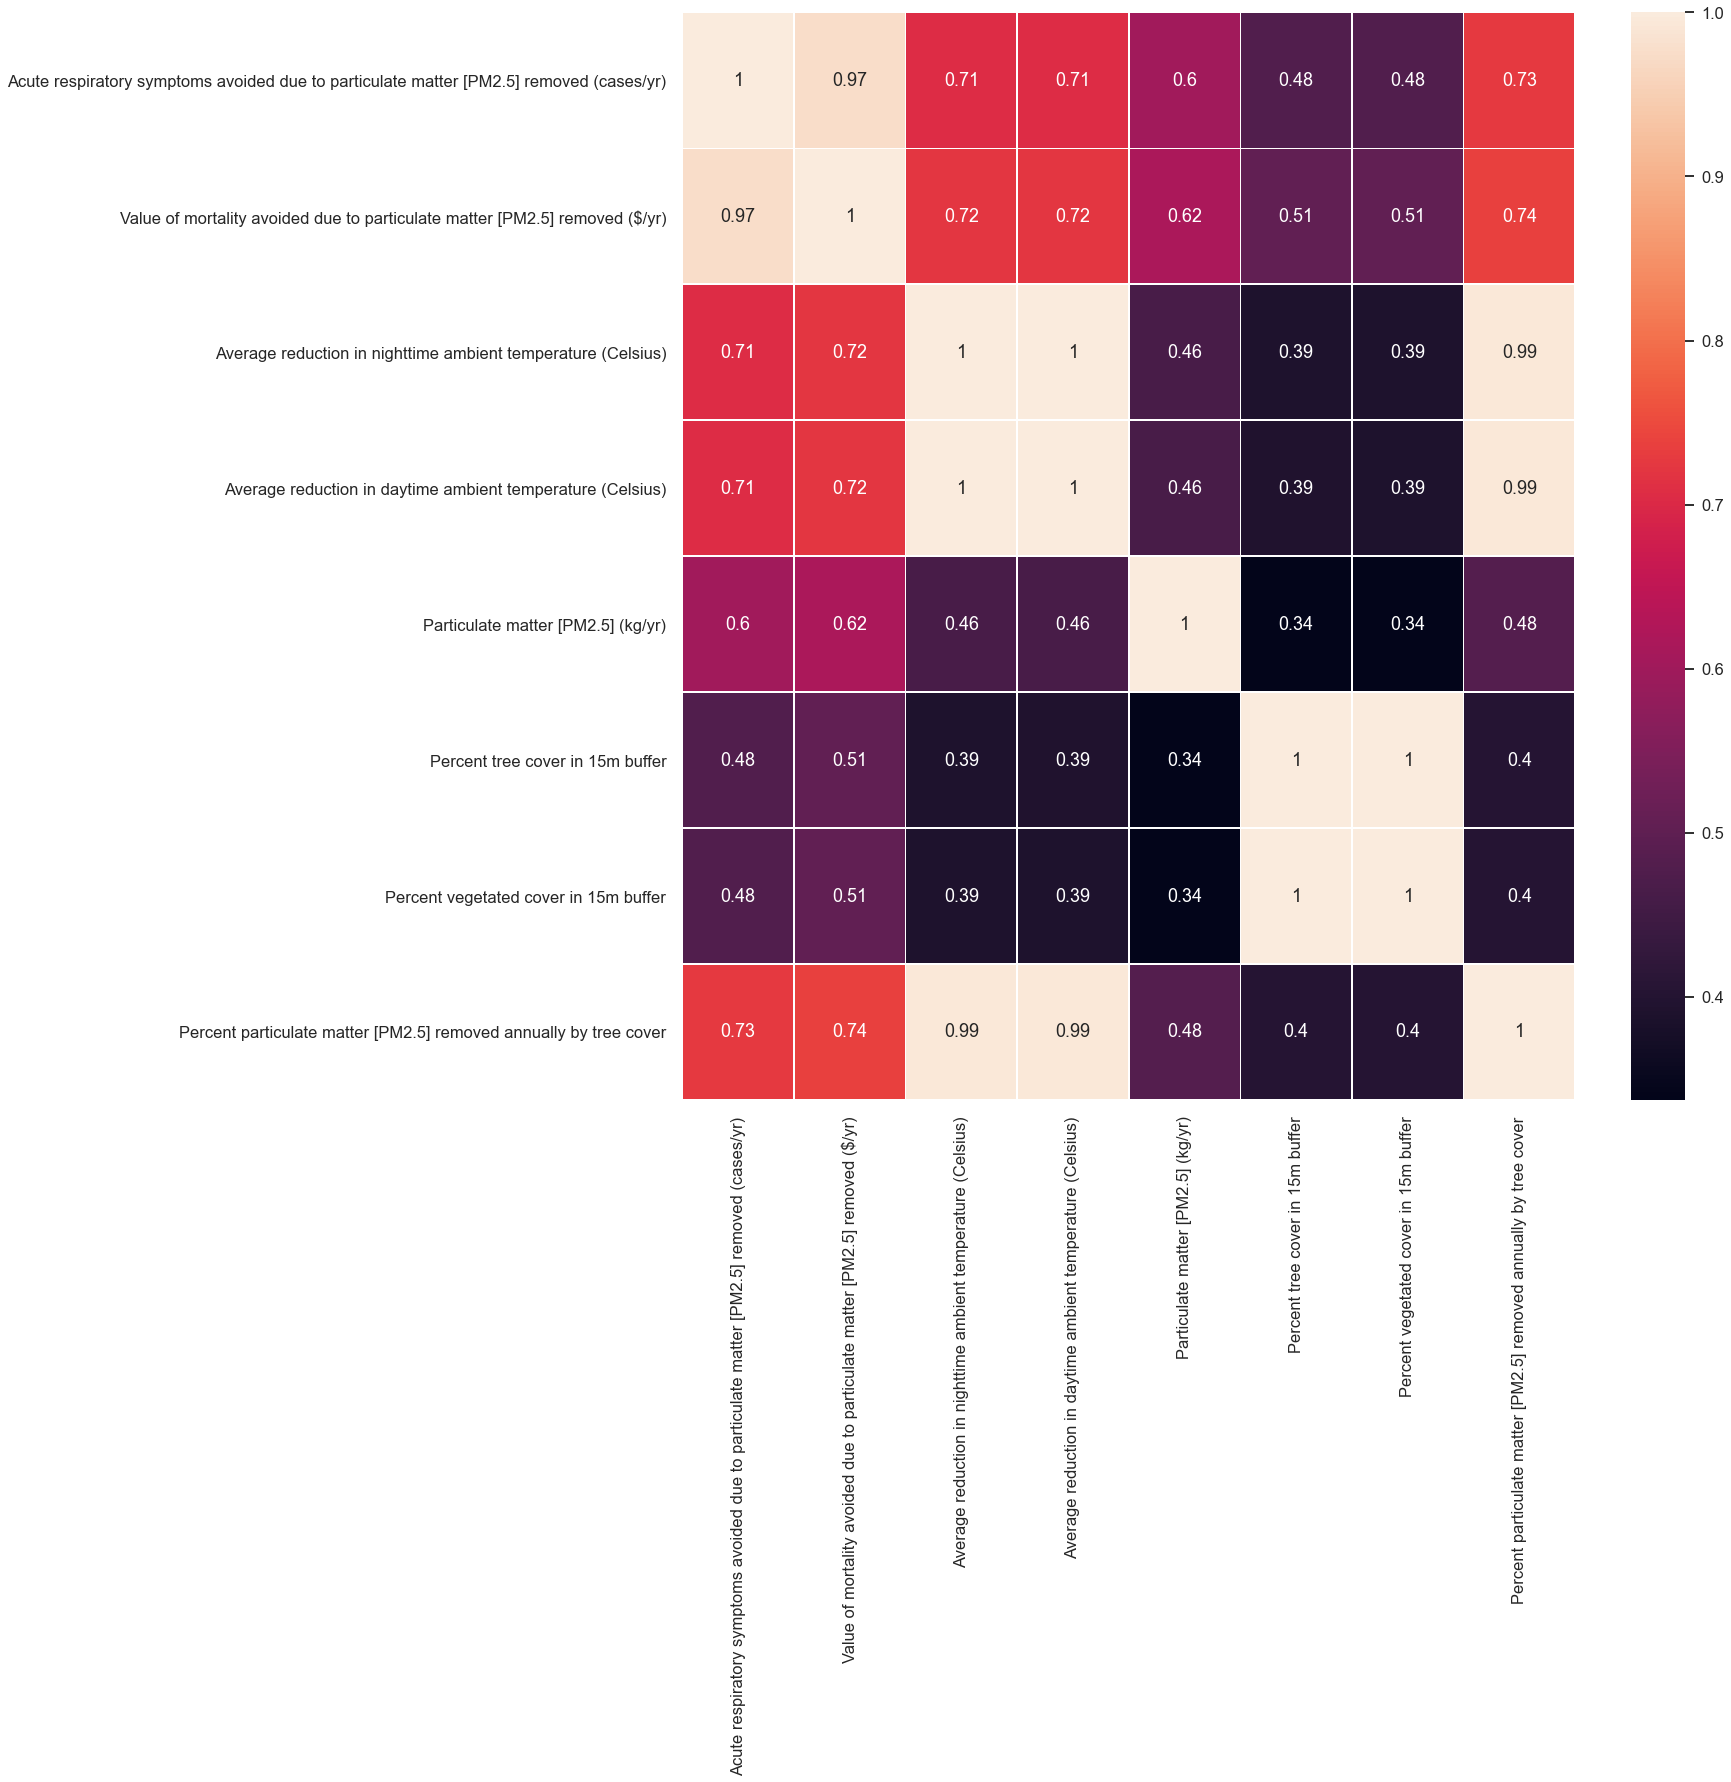

In [724]:
# Make heatmap of data
sns.set_context("talk")
_= plt.figure(figsize=(20,20))
heatmap = sns.heatmap(ds_ppm_analysis.corr(), annot=True, linewidth=0.6)
plt.show()

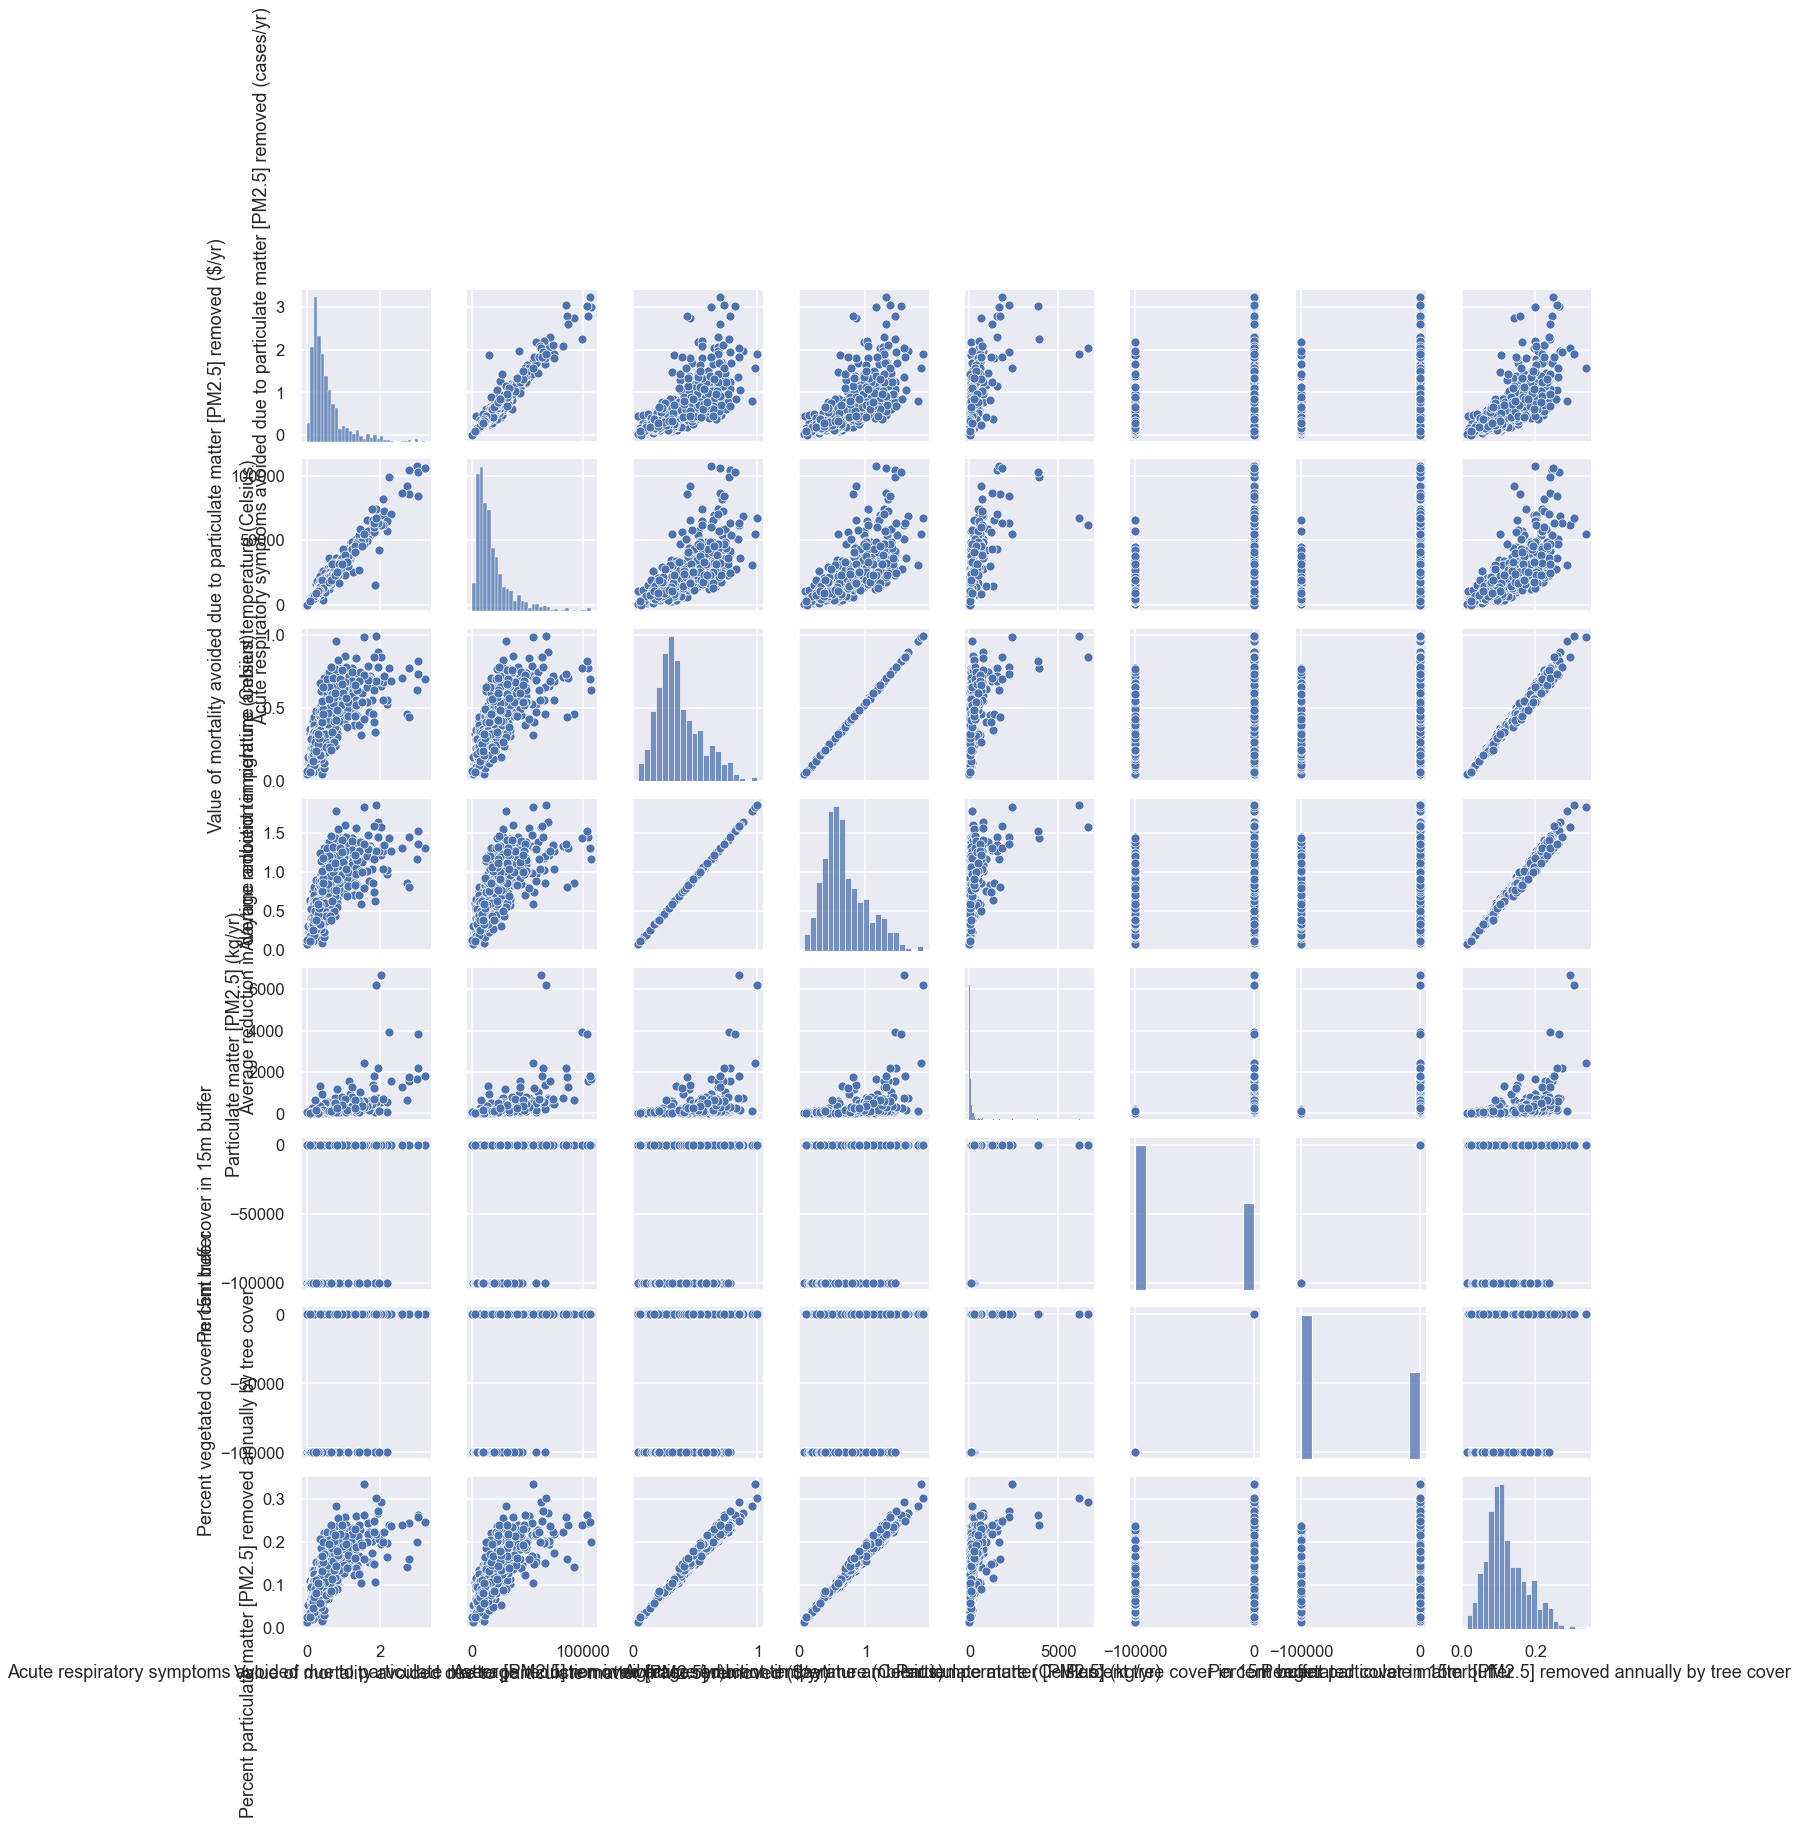

In [725]:
sns.pairplot(ds_ppm_analysis)

In [726]:
duplicateRowsDF = ds_ppm_analysis[ds_ppm_analysis.duplicated()]
duplicateRowsDF

,Acute respiratory symptoms avoided due to particulate matter [PM2.5] removed (cases/yr),Value of mortality avoided due to particulate matter [PM2.5] removed ($/yr),Average reduction in nighttime ambient temperature (Celsius),Average reduction in daytime ambient temperature (Celsius),Particulate matter [PM2.5] (kg/yr),Percent tree cover in 15m buffer,Percent vegetated cover in 15m buffer,Percent particulate matter [PM2.5] removed annually by tree cover


In [727]:
ds_ppm_analysis['Particulate matter [PM2.5] (kg/yr)'] = ds_ppm_analysis['Particulate matter [PM2.5] (kg/yr)'].astype(int)

<ipython-input-727-aac4605bd6dd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_ppm_analysis['Particulate matter [PM2.5] (kg/yr)'] = ds_ppm_analysis['Particulate matter [PM2.5] (kg/yr)'].astype(int)


In [728]:
ds_ppm_analysis['Particulate matter [PM2.5] (kg/yr)'].dtype

dtype('int32')

In [729]:
ds_ppm_analysis.head()

,Acute respiratory symptoms avoided due to particulate matter [PM2.5] removed (cases/yr),Value of mortality avoided due to particulate matter [PM2.5] removed ($/yr),Average reduction in nighttime ambient temperature (Celsius),Average reduction in daytime ambient temperature (Celsius),Particulate matter [PM2.5] (kg/yr),Percent tree cover in 15m buffer,Percent vegetated cover in 15m buffer,Percent particulate matter [PM2.5] removed annually by tree cover
0,0.241419,6914.820192,0.208037,0.386946,15,-99999.00,-99999.00,0.064822
1,0.381420,10924.783630,0.259908,0.486685,18,-99999.00,-99999.00,0.089630
2,0.274113,7351.426344,0.085852,0.157602,11,2.99,11.30,0.027520
3,0.180734,5809.611139,0.121610,0.227687,49,5.80,27.42,0.043109
4,0.291257,9362.305347,0.281127,0.530008,18,-99999.00,-99999.00,0.088673


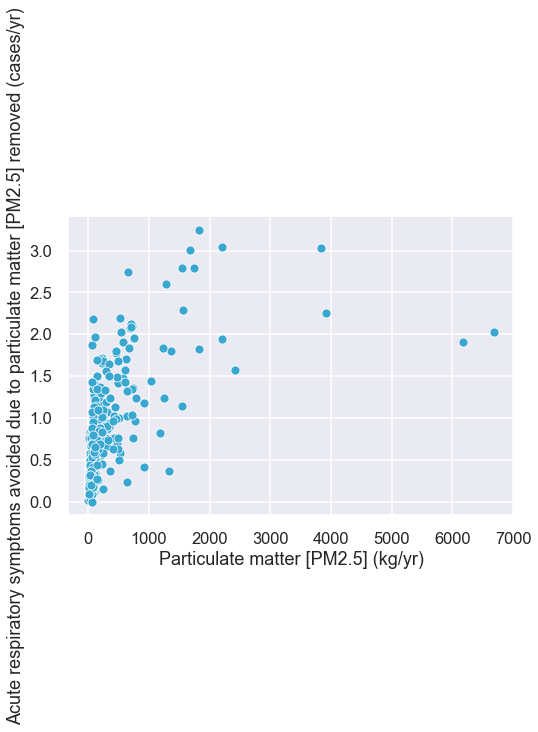

In [730]:
sns.set_style("darkgrid")
custom_palette = ["#39A7D0","#36ADA4"]
sns.set_palette(custom_palette)

sns.scatterplot(x='Particulate matter [PM2.5] (kg/yr)', y='Acute respiratory symptoms avoided due to particulate matter [PM2.5] removed (cases/yr)', data=ds_ppm_analysis)
plt.show()

<AxesSubplot:xlabel='Particulate matter [PM2.5] (kg/yr)', ylabel='Acute respiratory symptoms avoided due to particulate matter [PM2.5] removed (cases/yr)'>

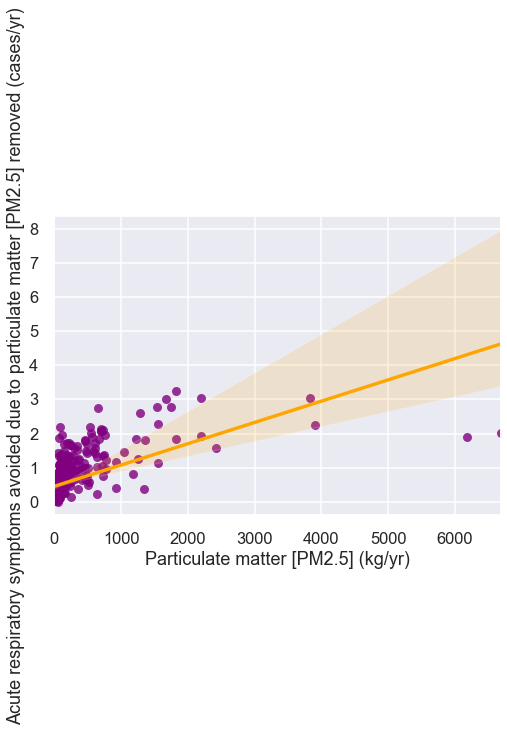

In [731]:
sns.regplot(x="Particulate matter [PM2.5] (kg/yr)", y="Acute respiratory symptoms avoided due to particulate matter [PM2.5] removed (cases/yr)", data=ds_ppm_analysis, scatter_kws={"color": "purple"}, line_kws={"color": "orange"})

In [732]:
ds_ppm_analysis.describe()

,Acute respiratory symptoms avoided due to particulate matter [PM2.5] removed (cases/yr),Value of mortality avoided due to particulate matter [PM2.5] removed ($/yr),Average reduction in nighttime ambient temperature (Celsius),Average reduction in daytime ambient temperature (Celsius),Particulate matter [PM2.5] (kg/yr),Percent tree cover in 15m buffer,Percent vegetated cover in 15m buffer,Percent particulate matter [PM2.5] removed annually by tree cover
count,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000
mean,0.555217,18621.026876,0.369258,0.687808,158.334270,-62478.883806,-62469.207935,0.120155
std,0.494855,16853.976420,0.175169,0.327112,477.889739,48472.315933,48484.815157,0.054614
min,0.000155,4.687211,0.044096,0.076473,0.000000,-99999.000000,-99999.000000,0.013209
25%,0.240700,7589.191775,0.246773,0.458284,19.000000,-99999.000000,-99999.000000,0.082131
50%,0.404176,13446.126545,0.330812,0.615510,38.500000,-99999.000000,-99999.000000,0.108825
75%,0.675749,22962.377615,0.465037,0.872741,100.250000,44.160001,79.224998,0.150262
max,3.244864,107453.585700,0.995412,1.856964,6685.000000,100.000000,100.000000,0.336143


## Split Train and Test Set

In [733]:
from sklearn.model_selection import train_test_split
# Split the data. This line uses the sklearn function train_test_split().
# The test_size parameter means we can train with 75% of the data, and test on 25%. 
x_train, x_test, y_train, y_test = train_test_split(ds_ppm_analysis["Particulate matter [PM2.5] (kg/yr)"], ds_ppm_analysis["Acute respiratory symptoms avoided due to particulate matter [PM2.5] removed (cases/yr)"], train_size = 0.75, test_size = 0.25, shuffle = True)

In [734]:
# We now want to check the shape of the X train, y_train, X_test and y_test to make sure the proportions are right. 
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(534,) (534,) (178,) (178,)


### Making a Linear Regression model: Model 1

In [735]:
import statsmodels.api as sm
from statsmodels.graphics.api import abline_plot 
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.model_selection import train_test_split 
from sklearn import linear_model, preprocessing # What does this do? Find out and type here.
import warnings 

rModel = linear_model.LinearRegression(normalize=True)
x_train_ = np.array(x_train).reshape(-1,1)
y_train_ = np.array(y_train).reshape(-1,1)
print(x_train_.shape, y_train_.shape)

(534, 1) (534, 1)


In [736]:
rModel.fit(x_train_, y_train_)

LinearRegression(normalize=True)

In [737]:
# Evaluate the model  
rModel.score(x_train_, y_train_)

0.3830902667232521

The above number is our R-squred coefficient. Model 1 explains only about 36% of the variation from the mean. Let's keep going.

In [738]:
x_test_ = np.array(x_test).reshape(-1,1)

In [739]:
# Use the model to make predictions about our test data
y_predict = rModel.predict(x_test_)

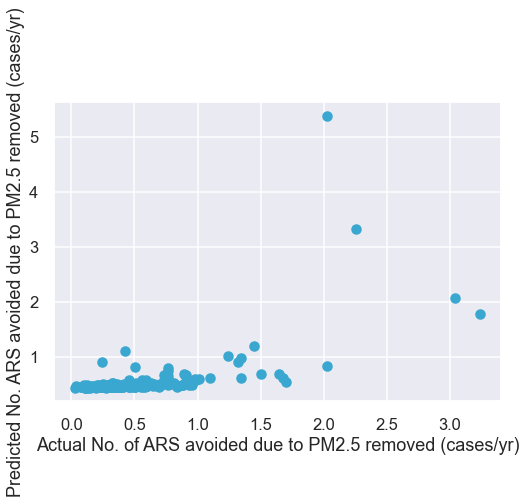

In [740]:
# Let's plot the predictions against the actual result. Use scatter()
_ = plt.scatter(y_test, y_predict)
_ = plt.xlabel("Actual No. of ARS avoided due to PM2.5 removed (cases/yr)")
_ = plt.ylabel("Predicted No. ARS avoided due to PM2.5 removed (cases/yr)")
plt.show()

## Multiple Linear Regression - Model 2

In [741]:
# Create test and train datasets
# This is again very similar, but now we include more columns in the predictors
# Include all columns from data in the explanatory variables X except fixed.acidity and quality (which was an integer)
x2 = ds_ppm_analysis.drop(["Acute respiratory symptoms avoided due to particulate matter [PM2.5] removed (cases/yr)"], axis=1)

# Create constants for X, so the model knows its bounds
x2 = sm.add_constant(x2)

# Split the data
y = ds_ppm_analysis[["Acute respiratory symptoms avoided due to particulate matter [PM2.5] removed (cases/yr)"]]
x2_train, x2_test, y_train, y_test = train_test_split(x2, y, test_size=0.25, shuffle=True)

In [742]:
# We can use almost identical code to create the third model, because it is the same algorithm, just different inputs
# Create the model
rModel_2 = sm.OLS(y_train, x2_train)

# Fit the model
fit_model2 = rModel_2.fit()

In [743]:
# Evaluate the model
fit_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                                               OLS Regression Results                                                              
===================================================================================================================================================
Dep. Variable:     Acute respiratory symptoms avoided due to particulate matter [PM2.5] removed (cases/yr)   R-squared:                       0.949
Model:                                                                                                 OLS   Adj. R-squared:                  0.948
Method:                                                                                      Least Squares   F-statistic:                     1392.
Date:                                                                                     Mon, 09 Aug 2021   Prob (F-statistic):               0.00
Time:                                                                                             16:33:06   Log-Likelihood:                 435.64
No. Observations:                                                                                      534   AIC:                            -855.3
Df Residuals:                                                                                          526   BIC:                            -821.0
Df Model:                                                                                                7                                         
Covariance Type:                                                                                 nonrobust                                         
===============================================================================================================================================
                                                                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------------
const                                                                           0.0070      0.023      0.301      0.763      -0.039       0.053
Value of mortality avoided due to particulate matter [PM2.5] removed ($/yr)  2.848e-05   5.04e-07     56.529      0.000    2.75e-05    2.95e-05
Average reduction in nighttime ambient temperature (Celsius)                   -0.2491      1.264     -0.197      0.844      -2.732       2.234
Average reduction in daytime ambient temperature (Celsius)                     -0.4163      0.690     -0.603      0.547      -1.772       0.939
Particulate matter [PM2.5] (kg/yr)                                           9.694e-06   1.19e-05      0.817      0.414   -1.36e-05     3.3e-05
Percent tree cover in 15m buffer                                                0.0013      0.000      2.538      0.011       0.000       0.002
Percent vegetated cover in 15m buffer                                          -0.0013      0.000     -2.539      0.011      -0.002      -0.000
Percent particulate matter [PM2.5] removed annually by tree cover               3.4557      0.840      4.115      0.000       1.806       5.106
==============================================================================
Omnibus:                      642.394   Durbin-Watson:                   2.068
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            89636.494
Skew:                           5.563   Prob(JB):                         0.00
Kurtosis:                      65.489   Cond. No.                     3.43e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.43e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Wow, Model 2 is predicting around 96% of the variation!

In [744]:
# Use our new model to make predictions
y2_predict = fit_model2.predict(x2_test)

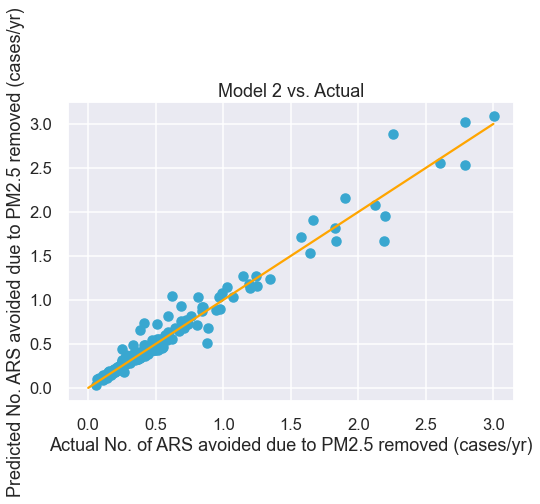

In [745]:
# Plot the predictions
# Build a scatterplot
_ = plt.scatter(y_test, y2_predict)
_ = plt.title("Model 2 vs. Actual")
_ = plt.xlabel("Actual No. of ARS avoided due to PM2.5 removed (cases/yr)")
_ = plt.ylabel("Predicted No. ARS avoided due to PM2.5 removed (cases/yr)")
# Add a line for perfect correlation
_ = plt.plot([x for x in range(0,4)], [x for x in range(0,4)], color = "orange")
plt.show()

Next, we'll try RMSE, since it is recommended that RMSE be used as the primary metric to interpret the model.

In [746]:
# Define a function to check the RMSE
def RMSE(predictions, actual):
    return np.sqrt(np.mean((predictions-actual) **2))

In [747]:
# Get predictions from rModel3
y2_predict = fit_model2.predict(x2_test)
# Put the predictions & actual values into a dataframe
df = pd.DataFrame(y_test)
df.rename(columns = {"Acute respiratory symptoms avoided due to particulate matter [PM2.5] removed (cases/yr)":"actual"}, inplace=True)
df["predicted"] = y2_predict

RMSE(df["predicted"], df["actual"])

0.10910196953139133

The RMSE tells us how far, on average, our predictions were mistaken. An RMSE of 0 would mean we were making perfect predictions. 0.14 signifies that we are, on average, about 0.09 of a unit of No. of Acute respiratory symptoms avoided due to PM2.5 removed (cases/yr) away from the correct answer.

## Analysis on Tree Canopy/Green Space

Using the same dataset, we will make an analysis on green space and tree canopy percentage. We'll have to do some cleaning on the data first.

Before we continue, let's define some key terms. **Tree Cover per capita**, the metric we will look at, provides a baseline for the percent of tree cover per capita in any given block group in the greater community.
Tree coverage takes many forms, including street trees, parks, urban forests, and single trees. on various properties. **Green space** is the square meters of total land per person within each census block group that is covered by vegetation, or green space. Green space may include trees, lawns and gardens, crop land, and wetlands.

In [748]:
ds_ppm.columns

Index(['OBJECTID',
       'Value of hospital admissions avoided due to nitrogen dioxide removed ($/yr)',
       'Asthma exacerbation avoided due to nitrogen dioxide removed (cases/yr)',
       'Value of asthma exacerbation cases avoided due to nitrogen dioxide removed ($/yr)',
       'Acute respiratory symptoms avoided due to ozone removed (cases/yr)',
       'Value of mortality avoided due to ozone removed ($/yr)',
       'School days not lost to illness due to ozone removed (days/yr)',
       'Value of school days not lost to illness due to ozone removed ($/yr)',
       'Acute respiratory symptoms avoided due to particulate matter [PM2.5] removed (cases/yr)',
       'Value of mortality avoided due to particulate matter [PM2.5] removed ($/yr)',
       'Asthma exacerbation avoided due to sulfur dioxide removed (cases/yr)',
       'Value of asthma exacerbation cases avoided due to sulfur dioxide removed ($/yr)',
       'Value of hospital admissions avoided due to sulfur dioxide removed 

In [749]:
ds_ppm['Green space per capita (m2/person)'].unique()

array([8.836000e+01, 1.034400e+02, 4.268000e+01, 5.146300e+02,
       1.195800e+02, 1.769000e+02, 2.347600e+02, 2.374300e+02,
       2.010100e+02, 2.167500e+02, 2.627700e+02, 3.473200e+02,
       1.043800e+02, 7.343400e+02, 1.955300e+02, 9.151000e+01,
       1.660300e+02, 4.179500e+02, 2.968000e+02, 1.179300e+02,
       9.596000e+01, 7.895000e+02, 1.114500e+02, 1.734100e+02,
       8.016000e+01, 1.273800e+02, 1.063000e+02, 1.603400e+02,
       3.372500e+02, 1.230000e+02, 1.147500e+02, 1.016900e+02,
       1.100400e+02, 1.213200e+02, 9.417000e+01, 6.054600e+02,
       5.936200e+02, 8.957000e+01, 2.322400e+02, 3.228200e+02,
       1.112000e+02, 3.420100e+02, 2.779000e+02, 2.502800e+02,
       4.075900e+02, 9.910000e+01, 1.057400e+02, 1.223200e+02,
       1.639800e+02, 8.328000e+01, 7.820000e+01, 2.256500e+02,
       2.569700e+02, 2.097900e+02, 1.847600e+02, 1.029330e+03,
       4.050700e+02, 2.024500e+02, 7.937000e+01, 1.508400e+02,
       6.383000e+01, 3.931000e+02, 3.189800e+02, 1.4366

In [750]:
ds_ppm['Tree cover per capita (m2/person)'].unique()

array([4.364000e+01, 4.804000e+01, 1.408000e+01, 1.587900e+02,
       7.923000e+01, 9.844000e+01, 1.062900e+02, 1.097600e+02,
       9.411000e+01, 9.329000e+01, 1.306800e+02, 1.668200e+02,
       4.471000e+01, 1.763700e+02, 8.722000e+01, 3.858000e+01,
       8.130000e+01, 1.515800e+02, 1.353300e+02, 5.598000e+01,
       4.071000e+01, 1.932500e+02, 4.465000e+01, 7.135000e+01,
       3.420000e+01, 4.891000e+01, 3.909000e+01, 6.721000e+01,
       2.100300e+02, 5.800000e+01, 4.949000e+01, 3.600000e+01,
       5.300000e+01, 5.612000e+01, 4.378000e+01, 2.398200e+02,
       3.326200e+02, 3.797000e+01, 1.115000e+02, 1.787400e+02,
       3.828000e+01, 1.098100e+02, 7.852000e+01, 6.346000e+01,
       2.978500e+02, 4.106000e+01, 3.761000e+01, 4.562000e+01,
       5.469000e+01, 3.387000e+01, 3.247000e+01, 1.087500e+02,
       1.124900e+02, 1.016500e+02, 7.953000e+01, 3.203900e+02,
       3.694000e+01, 5.536000e+01, 3.462000e+01, 5.937000e+01,
       2.549000e+01, 1.080300e+02, 1.125300e+02, 5.8700

In [751]:
ds_ppm_tc_subset = ds_ppm[['OBJECTID','Tree cover per capita (m2/person)','Green space per capita (m2/person)','Particulate matter [PM2.5] (kg/yr)']]

In [764]:
ds_ppm_tc_subset.head()

,OBJECTID,Tree cover per capita (m2/person),Green space per capita (m2/person),Particulate matter [PM2.5] (kg/yr)
0,1377,43.64,88.36,15.134235
1,1378,48.04,103.44,18.773267
2,1380,14.08,42.68,11.757580
3,1386,158.79,514.63,49.629855
4,1387,79.23,119.58,18.905682


In [765]:
# Create new dataframe 
ds_ppm_scaled = ds_ppm_tc_subset.set_index('OBJECTID')
# Save Crematoria labels
ds_ppm_index = ds_ppm_scaled.index
# Save column names
ds_ppm_columns = ds_ppm_scaled.columns
ds_ppm_scaled.head()

,Tree cover per capita (m2/person),Green space per capita (m2/person),Particulate matter [PM2.5] (kg/yr)
OBJECTID,,,
1377,43.64,88.36,15.134235
1378,48.04,103.44,18.773267
1380,14.08,42.68,11.757580
1386,158.79,514.63,49.629855
1387,79.23,119.58,18.905682


In [766]:
ds_ppm_scaled2 = scale(ds_ppm_scaled)

In [767]:
ds_ppm_scaled2

array([[-0.08519074, -0.05987553, -0.30096834],
       [-0.08443439, -0.05921824, -0.29334771],
       [-0.09027202, -0.06186658, -0.30803951],
       ...,
       [ 0.24256021,  0.07059877,  4.27894829],
       [ 0.57728502,  0.17962003,  3.4936886 ],
       [ 1.89029486,  0.55620463, 12.60715935]])

In [768]:
ds_ppm_scaled['Green space per capita (m2/person)']= ds_ppm_scaled['Green space per capita (m2/person)'].astype(int)

In [769]:
ds_ppm_scaled['Tree cover per capita (m2/person)']= ds_ppm_scaled['Tree cover per capita (m2/person)'].astype(int)

In [770]:
ds_ppm_scaled['Particulate matter [PM2.5] (kg/yr)']= ds_ppm_scaled['Particulate matter [PM2.5] (kg/yr)'].astype(int)

In [771]:
ds_ppm_scaled.head()

,Tree cover per capita (m2/person),Green space per capita (m2/person),Particulate matter [PM2.5] (kg/yr)
OBJECTID,,,
1377,43,88,15
1378,48,103,18
1380,14,42,11
1386,158,514,49
1387,79,119,18


In [772]:
ds_ppm_scaled.shape

(712, 3)

In [773]:
ds_ppm_tc_mean = ds_ppm_scaled['Tree cover per capita (m2/person)'].mean()
ds_ppm_tc_median = ds_ppm_scaled['Tree cover per capita (m2/person)'].median()
ds_ppm_tc__std = ds_ppm_scaled['Tree cover per capita (m2/person)'].std()
print(ds_ppm_tc_mean)
print(ds_ppm_tc_median)
print(ds_ppm_tc__std)
print((3-ds_ppm_tc_mean)/ds_ppm_tc__std)

538.7373595505618
111.5
5821.5438706424475
-0.09202668080064463


In [758]:
ds_ppm_scaled.apply(lambda x: x.mean(),axis=0)

Tree cover per capita (m2/person)      539.231643
Green space per capita (m2/person)    1462.065126
Particulate matter [PM2.5] (kg/yr)     158.853828
dtype: float64

In [759]:
ds_ppm_scaled.shape

(712, 3)

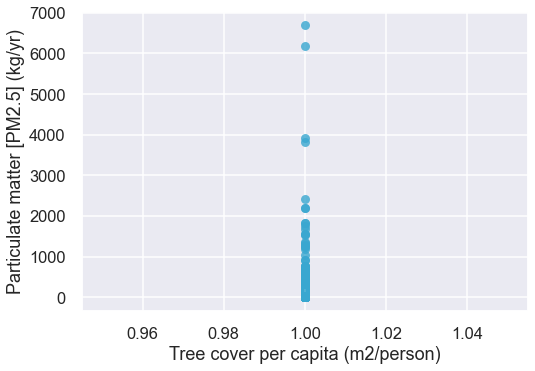

In [783]:
# There are some large outliers. Select values to narrow in on data.
ds_ppm_scaled['Tree cover per capita (m2/person)'] = ds_ppm_scaled['Tree cover per capita (m2/person)'] < 1000
sns.regplot(data=ds_ppm_scaled, x='Tree cover per capita (m2/person)', y='Particulate matter [PM2.5] (kg/yr)')
plt.show()

In [761]:
print('Max :',np.max(ds_ppm_scaled,axis=1))

Max : OBJECTID
1377       88.36
1378      103.44
1380       42.68
1386      514.63
1387      119.58
          ...   
2749     1186.57
2759     2457.11
2763     3081.79
2764     5583.03
2765    14222.89
Length: 712, dtype: float64


In [762]:
print('Min :',np.min(ds_ppm_scaled,axis=1))

Min : OBJECTID
1377      15.134235
1378      18.773267
1380      11.757580
1386      49.629855
1387      18.905682
           ...     
2749     234.691870
2759    1289.042978
2763    1950.310000
2764    1827.173852
2765    6179.074509
Length: 712, dtype: float64
